In [1]:
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq

import numpy.linalg as la
import scipy as sp 

import matplotlib.pyplot as plt
import seaborn as sns

from bokeh.plotting import figure, show
from bokeh.models import Band, BoxAnnotation, ColumnDataSource, VBar, Span, Legend
from bokeh.io import output_notebook
from bokeh.palettes import Category10
output_notebook()

Loading BokehJS ...

# Matrix experiments on interpretability

Versioned from "transform_matrix.ipynb

JMA 19 AUg 2024

In [2]:

# File dependencies:
model_data = pd.read_parquet("../understanding_classifiers/model_data_top_1k_descriptors.parquet").reset_index()
model_data.head()

,name,target,intercept,beta_scaling_factor,beta_unit_vector,model_xval_auc,descriptor_id
0,Humans,D006801,2.691081,21.267867,"[0.017268219613741725, -0.01062624505004475, -...",0.911437,D006801
1,Female,D005260,0.572347,8.489115,"[-0.008675035508034886, 0.004081205739551541, ...",0.767340,D005260
2,Male,D008297,0.405352,8.966750,"[0.0035645856617138984, -0.03874317638897351, ...",0.759039,D008297
3,Animals,D000818,-1.375631,23.026027,"[0.025583062634139626, 0.03199666405386238, 0....",0.945004,D000818
4,Adult,D000328,-0.445872,9.237172,"[0.0039388731307771225, 0.0067770643253572795,...",0.763687,D000328


## The coefficient vectors create the transform matrix from the semantic embedding space to the the interpretable concept space

Each row is one coefficient vector, for one of the label-terms, e.g. MeSH terms, that occupy the semantic embedding space. 

Stacking coefficient vectors in a matrix forms a transform from the embedding space to the concept space, whose dimensions are labeled by the label-terms. z

In [3]:
# Extract the vector field and expand it to multiple rows. 
concept_transforms = np.vstack((model_data.beta_unit_vector).map(lambda x: np.asarray(x)))
transform_names= model_data.name
row_count, column_count = concept_transforms.shape
f'output dimension: {row_count}, input dimension: {column_count}'

'output dimension: 1000, input dimension: 768'

In [4]:
# Both the numpy version and the scipy version return the same results. 


u,s, vh = la.svd(concept_transforms, full_matrices=False)
u.shape, len(s), vh.shape


((1000, 768), 768, (768, 768))

In [5]:
u_df = pd.DataFrame(u).set_index(transform_names)
u_df.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
name,,,,,,,,,,,,,,,,,,,,,
Humans,-0.052650,-0.021678,0.053388,0.020011,0.037313,0.000577,0.012473,0.044893,-0.003251,0.000484,...,-0.032495,0.068274,0.008440,-0.039427,-0.021804,-0.014797,0.007288,-0.008511,0.001061,-0.017222
Female,-0.060258,-0.038184,0.030440,0.031408,0.003135,0.020829,0.001572,0.023175,-0.012600,0.025587,...,0.001488,-0.013078,0.015550,-0.012815,0.026272,-0.047320,-0.036020,-0.050945,-0.002014,0.023693
Male,-0.039802,-0.043061,-0.001899,0.028714,-0.016116,0.004374,-0.005720,0.061326,-0.051550,0.024847,...,0.010381,0.071626,-0.004619,-0.002464,0.011473,0.039160,0.037762,0.036840,-0.020368,-0.031244
Animals,0.066046,0.026274,-0.034563,-0.030598,-0.008184,-0.002377,-0.017518,-0.057648,-0.000521,0.021073,...,0.025499,0.061632,0.071666,-0.014095,-0.017371,-0.033349,-0.027507,0.039577,0.037826,0.066013
Adult,-0.058607,-0.020626,0.036488,0.015864,-0.009581,-0.003604,-0.001819,0.012720,0.005415,-0.007565,...,0.006642,0.021043,-0.011107,0.027994,-0.063752,0.015039,-0.046780,-0.021869,-0.011935,0.008724


Text(0.5, 1.0, 'singular values magnitudes versus rank.')

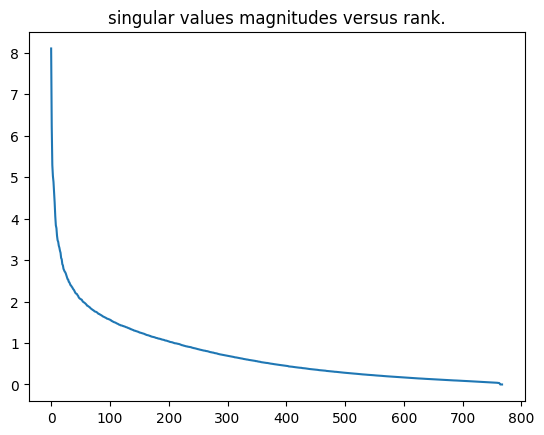

In [6]:
plt.plot(s)
plt.title('singular values magnitudes versus rank.')


In [7]:
# Check u for unit lengths along both axes.
np.any(np.apply_along_axis(la.norm, 0, u) - 1.0 < 1e4), np.any(np.apply_along_axis(la.norm, 1, u) - 1.0 < 1e4)


(np.True_, np.True_)

In [8]:
# Check v for unit lengths along both axes. 
np.any(np.apply_along_axis(la.norm, 0, vh) - 1.0 < 1e4), np.any(np.apply_along_axis(la.norm, 1, vh.T) - 1.0 < 1e4)

(np.True_, np.True_)

# Consider each column of U as a "concept" and see with which MeSH terms its associated
 
Each column is the result of setting just one non-zero S matrix entry == one orthogonal component in concept space. 

Another approach is simply to compute the PCA of the U matrix -- but since it's orthogonal we may already have that. 

## Prominent concepts in individual singular value "spaces"

Each singular value corresponds to one component in the orthogonal space that is common to both the input and output space.  This is an attempt to associate semantic labels from the concept space (the "MeSH" terms) with individual components.  The challenge is that the mapping from the component space (where the singular values live) to the concept space is dense, so each concept has some contributions to any given component.

The first component can be interpreted as "all encompassing", meaning it tries to capture as much as possible for the entire set of concepts. This "bland" component is colored by the bias of the entire set.  It is representative of the set. 

Subsequent components are orthogonal, and "peel off" more specific concepts.  We investigate them by listing the most positive and negative coefficients when transformed, using the u matrix to concept space. 



In [51]:
# Choose a top term not already chosen by going down the list. 
def choose_top_term(current_ranked_terms, existing_terms):
    term_in = 0
    top_term = current_ranked_terms[term_in]
    rejects = []
    while top_term in existing_terms:
        term_in += 1
        rejects.append([f'Rejected {top_term}', term_in])
        top_term = current_ranked_terms[term_in]
    return top_term, rejects

def one_component_terms(k, U_df, s):
    'k := the index of the component, equivalently the column'
    a_column = s[k] * U_df.iloc[:,k]
    a_column.sort_values(inplace=True, ascending=False)
    a_column = a_column.reset_index()
    a_column.columns = ['term', 'weight']
    return a_column.sort_index()

x_oct = one_component_terms(119, u_df, s)
x_oct

,term,weight
0,Drug Combinations,0.151087
1,Clinical Protocols,0.142580
2,Polymerase Chain Reaction,0.138619
3,Perception,0.135022
4,"Drug Resistance, Multiple, Bacterial",0.132858
...,...,...
995,Prefrontal Cortex,-0.128673
996,Nerve Net,-0.132829
997,RNA-Binding Proteins,-0.133146
998,Referral and Consultation,-0.166455


### "Taboo" listings of prominent component mesh terms.

Take the columns of the concept vectors with non-zero s values, sort the vector by coefficients to get those mesh terms most characteristic of each concept. Going down the list of s values, when a concept vector's top mesh term repeats one already assigned to a previous concept, take the top un-used mesh term instead.

The less repetition of the primary couple of mesh terms among components, the better.  So each component has a unique mesh term associated with it by disqualifying any term already associated with a component with a higher ranked singular value. 

In [ ]:
# Check how many duplicates among the top ranked mesh terms. 
# Create a data structure of ranked components. 
# First create a multi-index
sorted_mesh_term_weight_in = pd.MultiIndex.from_product([[f'sv_{n:.4}-{m}' for m, n in enumerate(s)], ['term', 'weight']], names = ['s-value', 'ranking'])

ranked_component = pd.DataFrame(index = range(row_count), columns=sorted_mesh_term_weight_in)
ranked_component = ranked_component.sort_index()
top_meshterm = [] # column_count * [None]
rejections = []

for j in range(column_count):
    # 
    component_in = sorted_mesh_term_weight_in[2*j][0]
    print(j, component_in)
    one_c = one_component_terms(j, u_df, s)
    
    top_term, r = choose_top_term(one_c['term'], top_meshterm )
    # Keep a record of which concepts have rejected top mesh terms. 
    rejection_cnt = len(r) 
    if rejection_cnt > 0:
        r.insert(0, j)
        rejections.append (r)
    while rejection_cnt > 0:
        one_c['term'][rejection_cnt-1] = None
        rejection_cnt -= 1
    ranked_component[component_in] = one_c
    top_meshterm.append(top_term)

In [54]:
# Save the ranked components
ranked_c_table = pa.Table.from_pandas(ranked_component)
pq.write_table(ranked_c_table, 'ranked_component.parquet')

In [55]:
# Save the list of rejected terms
with open('rejection_list.txt', 'w') as f:
    print(rejections, file=f,)
with open('top_meshterms_list.txt', 'w') as f:
    print(top_meshterm, file=f,)

In [57]:
# How many times does a top -ranked meshterm re-appear?
# A lot it turns out. 
len(rejections)

380